In [14]:
import numpy as np
import pandas as pd
import bloscpack as bp

from sklearn.model_selection import StratifiedKFold

import imgaug as ia
import imgaug.augmenters as iaa

from torch.utils.data.dataloader import DataLoader

import fastai
from fastai.vision import *
from fastai.callbacks import *

from optim import Over9000
from data import Bengaliai_DS
from models_mg import Seresnext50MishGeM
from callback_utils import SaveModelCallback
from mixup_fastai_utils import CmCallback, MuCmCallback, MixUpCallback
from loss import Loss_combine_weighted
from metric import Metric_grapheme, Metric_vowel, Metric_consonant, Metric_tot

from tqdm import tqdm

---

In [2]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

---
### data

In [3]:
pdf = pd.read_csv('../input/train.csv')
unique_grapheme = pdf['grapheme'].unique()
grapheme_code = dict([(g, c) for g, c in zip(unique_grapheme, np.arange(unique_grapheme.shape[0]))])
pdf['grapheme_code'] = [grapheme_code[g] for g in pdf['grapheme']]

skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
for trn_ndx, vld_ndx in skf.split(pdf['grapheme_code'], pdf['grapheme_code']):
    break
    
imgs = bp.unpack_ndarray_from_file('../features/train_images_size128_pad3.bloscpack')
lbls = pd.read_csv('../input/train.csv').iloc[:, 1:4].values

trn_imgs = imgs[trn_ndx]
trn_lbls = lbls[trn_ndx]
vld_imgs = imgs[vld_ndx]
vld_lbls = lbls[vld_ndx]

In [4]:
augs = iaa.SomeOf(
    (0, 2),
    [
        iaa.OneOf(
            [
                iaa.Affine(scale={"x": (0.8, 1.), "y": (0.8, 1.)}, rotate=(-15, 15), shear=(-15, 15)),
                iaa.PerspectiveTransform(scale=.08, keep_size=True),
            ]
        ),
        iaa.PiecewiseAffine(scale=(.02, .03)),
    ],
    random_order=True
)

In [5]:
batch_size = 64 # 64 is important as the fit_one_cycle arguments are probably tuned for this batch size

training_set = Bengaliai_DS(trn_imgs, trn_lbls, transform=augs)
validation_set = Bengaliai_DS(vld_imgs, vld_lbls)

training_loader = DataLoader(training_set, batch_size=batch_size, num_workers=6, shuffle=True) # , sampler=sampler , shuffle=True
validation_loader = DataLoader(validation_set, batch_size=batch_size, num_workers=6, shuffle=False)

data_bunch = DataBunch(train_dl=training_loader, valid_dl=validation_loader)

---
### model

In [6]:
device = 'cuda:0'
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant

In [7]:
classifier = Seresnext50MishGeM()
save = torch.load('new_baseline_seresnext50MishGeM_lastBN_LessAugs_712_Mu10_Wd0_64epochs.pth')
classifier.load_state_dict(save)

In [11]:
classifier = classifier.cuda()

In [15]:
vld_preds = []

for vld_img_batch, vld_lbl_batch in tqdm(validation_loader):
    vld_img_batch = vld_img_batch.cuda()
    vld_pred_g, vld_pred_v, vld_pred_c = classifier(vld_img_batch)
    
    vld_pred_g = vld_pred_g.detach().cpu().numpy().argmax(1).astype('uint16')
    vld_pred_v = vld_pred_v.detach().cpu().numpy().argmax(1).astype('uint16')
    vld_pred_c = vld_pred_c.detach().cpu().numpy().argmax(1).astype('uint16')
    
    vld_preds.append(np.stack([vld_pred_g, vld_pred_v, vld_pred_c], 1))

100%|██████████| 449/449 [00:21<00:00, 20.97it/s]


In [16]:
vld_preds = np.concatenate(vld_preds, 0)

In [17]:
vld_lbls.shape

(28692, 3)

In [25]:
root_errors = vld_preds[vld_preds[:, 0] != vld_lbls[:, 0]]
root_errors_truth = vld_lbls[vld_preds[:, 0] != vld_lbls[:, 0]]

In [26]:
root_errors.shape

(1099, 3)

In [30]:
# root error frequency
errs, cnts = np.unique(root_errors[:, 0], return_counts=True)

<BarContainer object of 146 artists>

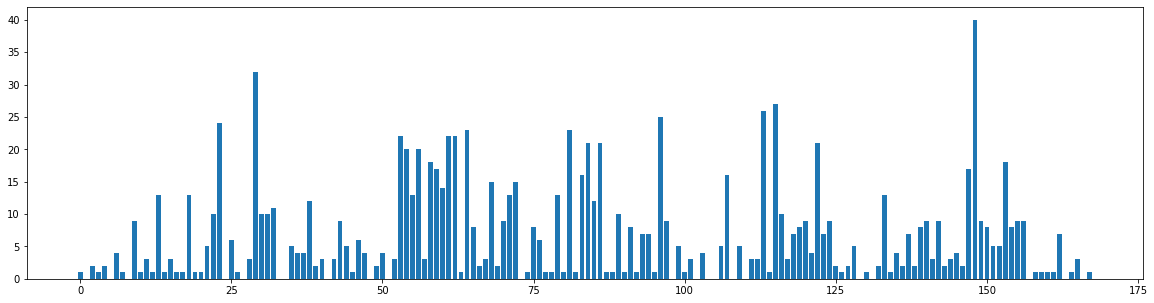

In [35]:
_, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.bar(errs, cnts)

In [49]:
root_errors[root_errors[:, 0] == 9]

array([[9, 7, 0],
       [9, 0, 0],
       [9, 0, 0],
       [9, 0, 0],
       [9, 0, 0],
       [9, 7, 0],
       [9, 0, 6],
       [9, 0, 4],
       [9, 7, 0]], dtype=uint16)

In [48]:
root_errors_truth[root_errors[:, 0] == 9]

array([[113,   7,   0],
       [ 64,   0,   5],
       [ 64,   0,   5],
       [ 64,   0,   5],
       [ 64,   0,   5],
       [ 64,   7,   5],
       [ 64,   0,   6],
       [ 64,   0,   6],
       [ 64,   7,   5]])

In [81]:
a = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]).astype(int)
b = np.stack([a, a], 0)

In [82]:
c = np.repeat(b[None, :, :, :], 10, axis=0)

In [83]:
d = torch.from_numpy(c)

In [88]:
d[0, 0]

tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16]])

In [84]:
e = d.view(-1, 2, 16)

In [89]:
e[0, 0]

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [85]:
d[0, 0, 0, 0]

tensor(1)

In [87]:
e[0, 0, 0]

tensor(1)

In [101]:
f = torch.Tensor([0, 1, 2, 3, 4, 7, 8, 11, 12, 13, 14, 15]).long()
g = torch.Tensor([5, 6, 9, 10]).long()

In [106]:
e[:2, :, g]

tensor([[[ 6,  7, 10, 11],
         [ 6,  7, 10, 11]],

        [[ 6,  7, 10, 11],
         [ 6,  7, 10, 11]]])

In [105]:
torch.sum(e[:, :, g], -1)

tensor([[34, 34],
        [34, 34],
        [34, 34],
        [34, 34],
        [34, 34],
        [34, 34],
        [34, 34],
        [34, 34],
        [34, 34],
        [34, 34]])